# Exploratory data analysis and modelling

First, we will look at the distributions of features and relationships between them. 
After that we split the data, fit and optimize models and lastly sum up the results.


In [103]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
plt.style.use('ggplot')


In [104]:
# import cleaned dataset
df = pd.read_csv('data/dataset_cleaned.csv')
# drop index column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [105]:
# if value is 0 or 'missing', replace with NaN
df = df.replace(0, np.nan)
df = df.replace('missing', np.nan)

# drop columns with more than 50% missing values
df.dropna(thresh=len(df)*0.25, axis=1, inplace=True)


In [106]:
# see the statictical summary of the numerical columns
df.describe().round(0)


,Price,SurfaceArea,YearBuilt,TotalFloorsInBuilding,YearRenovated,TotalRooms,LandArea
count,1985.0,1398.0,1896.0,579.0,742.0,736.0,516.0
mean,247817.0,144.0,1966.0,4.0,2010.0,5.0,487.0
std,178323.0,110.0,58.0,3.0,14.0,2.0,256.0
min,1.0,1.0,1500.0,1.0,1900.0,1.0,1.0
25%,125000.0,71.0,1953.0,2.0,2005.0,3.0,296.0
50%,196000.0,110.0,1979.0,3.0,2013.0,5.0,464.0
75%,320000.0,182.0,2006.0,5.0,2019.0,6.0,686.0
max,999999.0,889.0,2024.0,21.0,2022.0,10.0,999.0


In [107]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  1985 non-null   int64  
 1   SurfaceArea            1398 non-null   float64
 2   ApartmentType          792 non-null    object 
 3   YearBuilt              1896 non-null   float64
 4   ApartmentSetting       523 non-null    object 
 5   TotalFloorsInBuilding  579 non-null    float64
 6   YearRenovated          742 non-null    float64
 7   BalconyTerraceAtrium   705 non-null    object 
 8   Furniture              706 non-null    object 
 9   NetArea                1194 non-null   object 
 10  EnergyClass            924 non-null    object 
 11  TotalRooms             736 non-null    float64
 12  HouseMaterial          548 non-null    object 
 13  HouseType              1061 non-null   object 
 14  LandArea               516 non-null    float64
 15  Regi

Price
SurfaceArea
ApartmentType


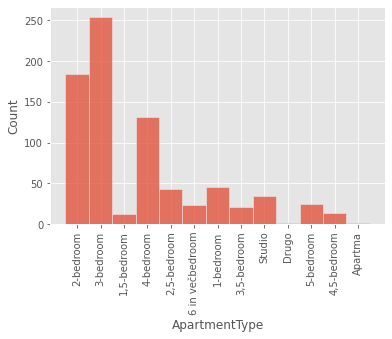

YearBuilt
ApartmentSetting


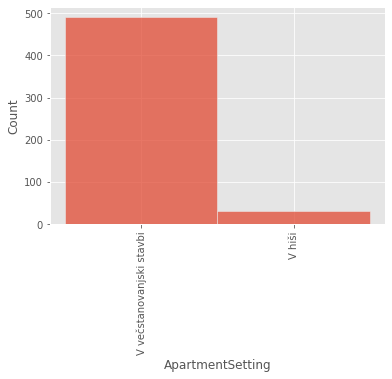

TotalFloorsInBuilding
YearRenovated
BalconyTerraceAtrium


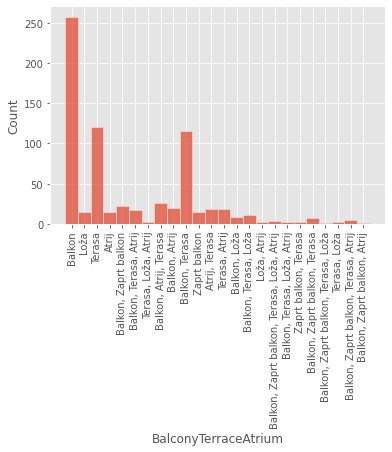

Furniture


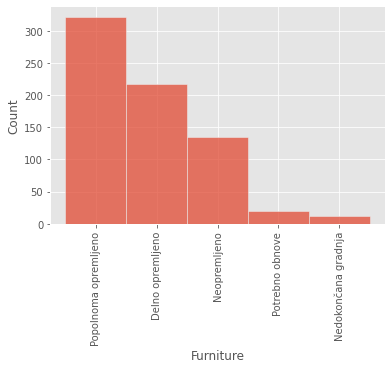

NetArea
EnergyClass
TotalRooms
HouseMaterial


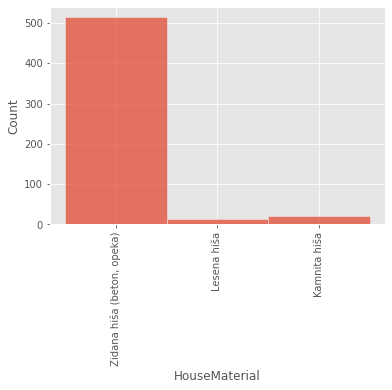

HouseType


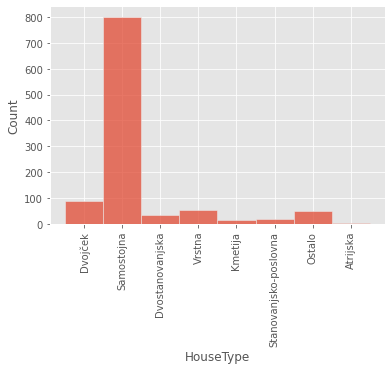

LandArea
Region


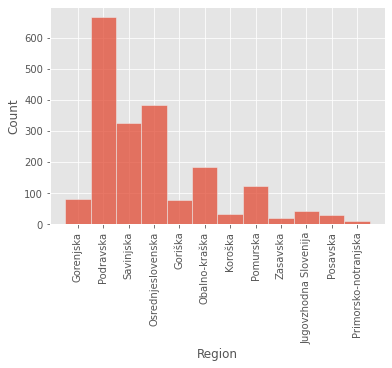

District
Neighborhood


<Figure size 432x288 with 0 Axes>

In [108]:
for label in df.columns:
  print(label)
  if(df[label].dtype == 'object') and (len(list(df[label].unique())) <= 25):
    sns.histplot(data=df, x=label)
    # set labels
    plt.xticks(rotation = '90')
    #plt.tight_layout()
    # save img
    plt.rcParams.update({
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"})

    plt.savefig('histogram_' + label + '.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.clf()

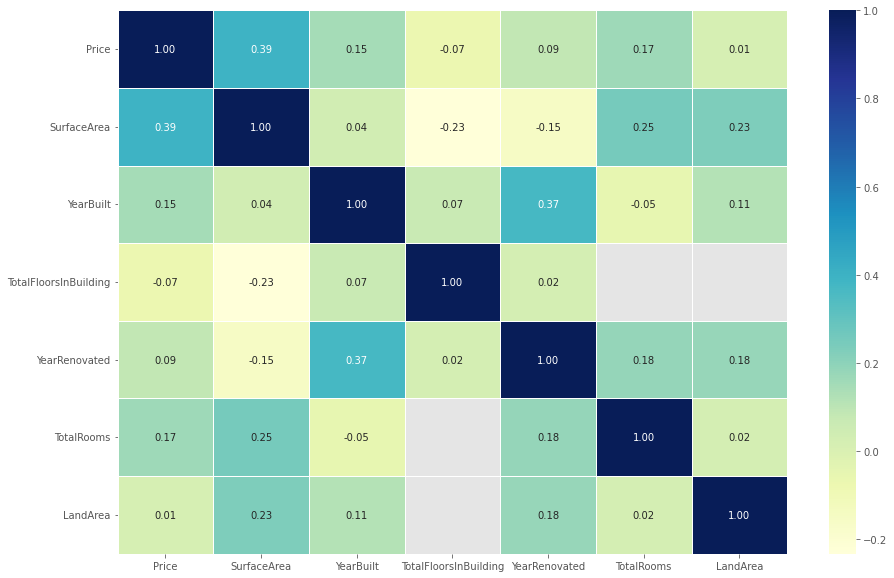

In [109]:
# create a correlation matrix
corr_matrix = df.corr()

# plot the correlation matrix
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                  annot=True,
                  linewidths=0.5,
                  fmt=".2f",
                  cmap="YlGnBu");
                    

In [110]:
# average price per m2
df['PricePerM2'] = df['Price'] / df['SurfaceArea'].round(0)
df['PricePerM2'].describe().round(0)


count      1398.0
mean       2368.0
std        8072.0
min           0.0
25%        1082.0
50%        1861.0
75%        2877.0
max      299000.0
Name: PricePerM2, dtype: float64

<AxesSubplot:xlabel='Price'>

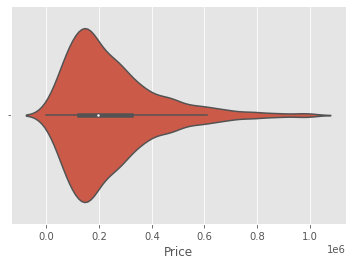

In [115]:
# plot price distribution
sns.violinplot(data=df, x='Price')



In [112]:
# count how many values for price are above 1 mio
df[df['Price'] > 1000000].shape[0]

0

<AxesSubplot:xlabel='SurfaceArea', ylabel='Price'>

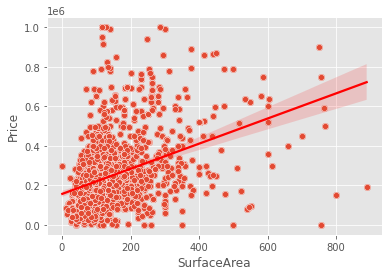

In [121]:
# scaterplot price and surface area with a regression line
sns.regplot(data=df, x='SurfaceArea', y='Price', line_kws={'color': 'red'})
sns.scatterplot(data=df, x='SurfaceArea', y='Price')

In [ ]:
# regression and scatteršplot for price and surface area
sns.regplot(data=df, x='SurfaceArea', y='Price')
sns.scatterplot(data=df, x='SurfaceArea', y='Price')
# set labels


# Encode data, split dataframe and fit models

In [113]:
# import the models, metrics and cross validation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold
np.set_printoptions(precision=4)

In [122]:
train, test = train_test_split(df, test_size=0.2, random_state = 42)

In [124]:
# impute categorical columns with LabelEncoder
def ImputeCategoricalFeatures(df):
    # Find the columns of object type along with their column index
    object_cols = list(df.select_dtypes(exclude=[np.number]).columns)
    object_cols_ind = []
    for col in object_cols:
        object_cols_ind.append(df.columns.get_loc(col))

    # Encode the categorical columns with numbers
    label_enc = LabelEncoder()
    encoders = {}
    
    
    for i in object_cols_ind:
        df.iloc[:,i] = label_enc.fit_transform(df.iloc[:,i])
        encoders[i] = label_enc
    return df

In [126]:
train_imp = ImputeCategoricalFeatures(train)
test_imp = ImputeCategoricalFeatures(test)

In [127]:
# split the data into X and y
X_train = train_imp.drop('Price', axis =1)
y_train = np.ravel(np.array(train_imp[['Price']]))
X_test = test_imp.drop('Price', axis =1)
y_test = np.ravel(np.array(test_imp[['Price']]))

In [128]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1588, 18)
(1588,)
(397, 18)
(397,)


In [129]:
# define the valuation metrics
# mae
def mse(y_test, y_preds):
    return mean_squared_error(y_test, y_preds)

# rmse
def rmse(y_test, y_preds):
    return np.sqrt(mean_squared_error(y_test, y_preds))

# mape
def mape(y_test, y_preds):
    return np.mean(np.abs((y_test - y_preds) / y_test)) * 100

# R2
def r2(y_test, y_preds):
    return r2_score(y_test, y_preds)

# rmsle
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_error(np.log(y_test), np.log(y_preds)))



SyntaxError: invalid syntax (4162135773.py, line 5)

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
%%time
# random forest regressor
rf_model = RandomForestRegressor(#n_estimators=300,
                                      #max_depth=10,
                                      #min_samples_split=5,
                                      #min_samples_leaf=5,
                                      #max_features=None,
                                      random_state=42,
                                      #oob_score=True
                                     )
kf = KFold(n_splits=5)
y_pred_rf = cross_val_score(rf_model, X_train, y_train, cv=kf, n_jobs=-1)
print(y_pred_rf.mean())
print(y_pred_rf)

In [ ]:
%%time
rf_model.fit(X_train, y_train)
y_train_pred_rf = rf_model.predict(X_train)

print('train RMSLE: ' + str(rmsle(y_train, y_train_pred_rf)))

y_test_pred_rf = rf_model.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_rf)))
rf_model.get_params()

In [ ]:
sorted_idx = rf_model.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), rf_model.feature_importances_[sorted_idx])

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train, plot_type="dot")

In [ ]:
%%time
gboost_model = GradientBoostingRegressor(#n_estimators=500, learning_rate=0.01,
                                     #max_depth=5, max_features='sqrt',
                                     #min_samples_leaf=15, min_samples_split=10,
                                     #loss='ls', random_state =42
                                   )


kf = KFold(n_splits=5)
y_pred_gboost = cross_val_score(gboost_model, X_train, y_train, cv=kf, n_jobs=-1)
print(y_pred_gboost.mean())
print(y_pred_gboost)

In [ ]:
%%time
gboost_model.fit(X_train, y_train)

y_train_pred_gboost = gboost_model.predict(X_train)
print('train RMSLE: ' + str(rmsle(y_train, y_train_pred_gboost)))

y_test_pred_gboost = gboost_model.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_gboost)))
gboost_model.get_params()

In [ ]:
sorted_idx = gboost_model.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), gboost_model.feature_importances_[sorted_idx])

In [ ]:
explainer = shap.TreeExplainer(gboost_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
%%time
xgboost_model = XGBRegressor(#learning_rate=0.01,
                         #n_estimators=1000,
                         #max_depth=4, min_child_weight=1,
                         #gamma=0.6, subsample=0.7,
                         #colsample_bytree=0.2,
                         #nthread=-1,
                         #scale_pos_weight=1, seed=27,
                         #reg_alpha=0.001
                       )

kf = KFold(n_splits=5)
y_pred_xgboost = cross_val_score(xgboost_model, X_train, y_train, cv=kf, n_jobs=-1)
print(y_pred_xgboost.mean())
print(y_pred_xgboost)

In [ ]:
%%time
xgboost_model.fit(X_train, y_train)

y_train_pred_xgboost = xgboost_model.predict(X_train)
print('train RMSLE: ' + str(rmsle(y_train, y_train_pred_xgboost)))

y_test_pred_xgboost = xgboost_model.predict(X_test)
print('test RMSLE: ' + str(rmsle(y_test, y_test_pred_xgboost)))